In [21]:
# Code from src/preprocessor.py

import cv2
import numpy as np
from skimage import color
from typing import Callable, Literal
from skimage.feature import (
    hog,
    local_binary_pattern,
    blob_dog,
    blob_log,
    blob_doh,
    canny,
    daisy,
    hessian_matrix_det,
    multiblock_lbp,
    corner_fast,
)


def extract_hog_features(img) -> tuple[np.ndarray, np.ndarray]:
    """Extract HOG features from the given image in grayscale."""
    img = color.gray2rgb(img) if len(img.shape) == 2 else img
    fd, img = hog(
        img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm="L2-Hys", channel_axis=-1, visualize=True
    )
    return np.array(fd), img


def extract_lbp_features(img) -> np.ndarray:
    """Extract LBP features from the given dataset."""
    return np.array(local_binary_pattern(img, 8, 1, method="uniform"))


def extract_blob_features(img, blob_type: Literal["dog", "log", "doh"] = "dog") -> np.ndarray:
    """Extract blob features from the given dataset."""
    blob_type = blob_type.lower()
    blob_map: dict[str, Callable] = {
        "dog": blob_dog,
        "log": blob_log,
        "doh": blob_doh,
    }
    if blob_type not in blob_map:
        raise ValueError(f"Invalid blob type: {blob_type}")
    blob_func = blob_map[blob_type]
    # length of the feature vector should be 256 if the features dont have size 256 pad with zeros
    res = blob_func(img, max_sigma=30, threshold=0.1 if blob_type != "doh" else 0.01)
    if res.shape[0] < 256:
        return np.pad(res, ((0, 256 - res.shape[0]), (0, 0)), mode="constant")
    return np.array(res)


def extract_canny_features(img) -> np.ndarray:
    """Extract canny features from the given dataset."""
    return np.array(canny(img, sigma=3))


def extract_daisy_features(img) -> tuple[np.ndarray, np.ndarray]:
    """Extract daisy features from the given dataset."""
    descs, descs_img = daisy(img, step=180, radius=58, rings=2, histograms=6, orientations=8, visualize=True)
    return np.array(descs), descs_img


def extract_hessian_features(img) -> np.ndarray:
    """Extract hessian features from the given dataset."""
    return np.array(hessian_matrix_det(img, sigma=1.0))


def extract_multiblock_lbp_features(img) -> np.ndarray:
    """Extract multiblock lbp features from the given dataset."""
    return np.array(multiblock_lbp(img, r=3, c=3, width=8, height=8))


def extract_histogram_features(img) -> np.ndarray:
    """Extract histogram features from the given dataset."""
    return np.array(cv2.calcHist([img], [0], None, [256], [0, 256]).flatten())


def extract_corner_features(img) -> np.ndarray:
    """Extract corner features from the given dataset."""
    return np.array(corner_fast(img))

In [22]:
# Map taken from src/svm.py
feautes_map = [
    ("hog", extract_hog_features, ()),
    ("lbp", extract_lbp_features, ()),
    ("blob_dog", extract_blob_features, ("dog",)),
    ("blob_log", extract_blob_features, ("log",)),
    ("blob_doh", extract_blob_features, ("doh",)),
    ("canny", extract_canny_features, ()),
    ("daisy", extract_daisy_features, ()),
    ("hessian", extract_hessian_features, ()),
    ("multiblock_lbp", extract_multiblock_lbp_features, ()),
    ("histogram", extract_histogram_features, ()),
    ("corner", extract_corner_features, ()),
]

In [23]:
import os

path = os.path.join("..", "data", "a2", "data", "train", "livingroom", "image_0035.jpg")

In [24]:
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img_ft = {}

img_ft["none"] = img
for feature_name, feature_func, feature_args in feautes_map:
    print(f"Extracting {feature_name} features...")
    img_ft[feature_name] = feature_func(img, *feature_args)

Extracting hog features...
Extracting lbp features...
Extracting blob_dog features...
Extracting blob_log features...
Extracting blob_doh features...
Extracting canny features...
Extracting daisy features...
Extracting hessian features...
Extracting multiblock_lbp features...
Extracting histogram features...
Extracting corner features...


In [25]:
for ft_name, _, _ in feautes_map:
    ft = img_ft[ft_name]
    if isinstance(ft, tuple):
        print(f"{ft_name}: {ft[0].shape}, {ft[1].shape}")
    else:
        print(f"{ft_name}: {ft.shape}")

hog: (1872,), (220, 292)
lbp: (220, 292)
blob_dog: (256, 3)
blob_log: (256, 3)
blob_doh: (256, 3)
canny: (220, 292)
daisy: (1, 1, 104), (220, 292, 3)
hessian: (220, 292)
multiblock_lbp: ()
histogram: (256,)
corner: (220, 292)


In [26]:
from skimage.feature import draw_multiblock_lbp

img_mlbp = img_ft["multiblock_lbp"]
img_ft["multiblock_lbp"] = draw_multiblock_lbp(img, 0, 0, 90, 90, lbp_code=img_mlbp, alpha=0.5)

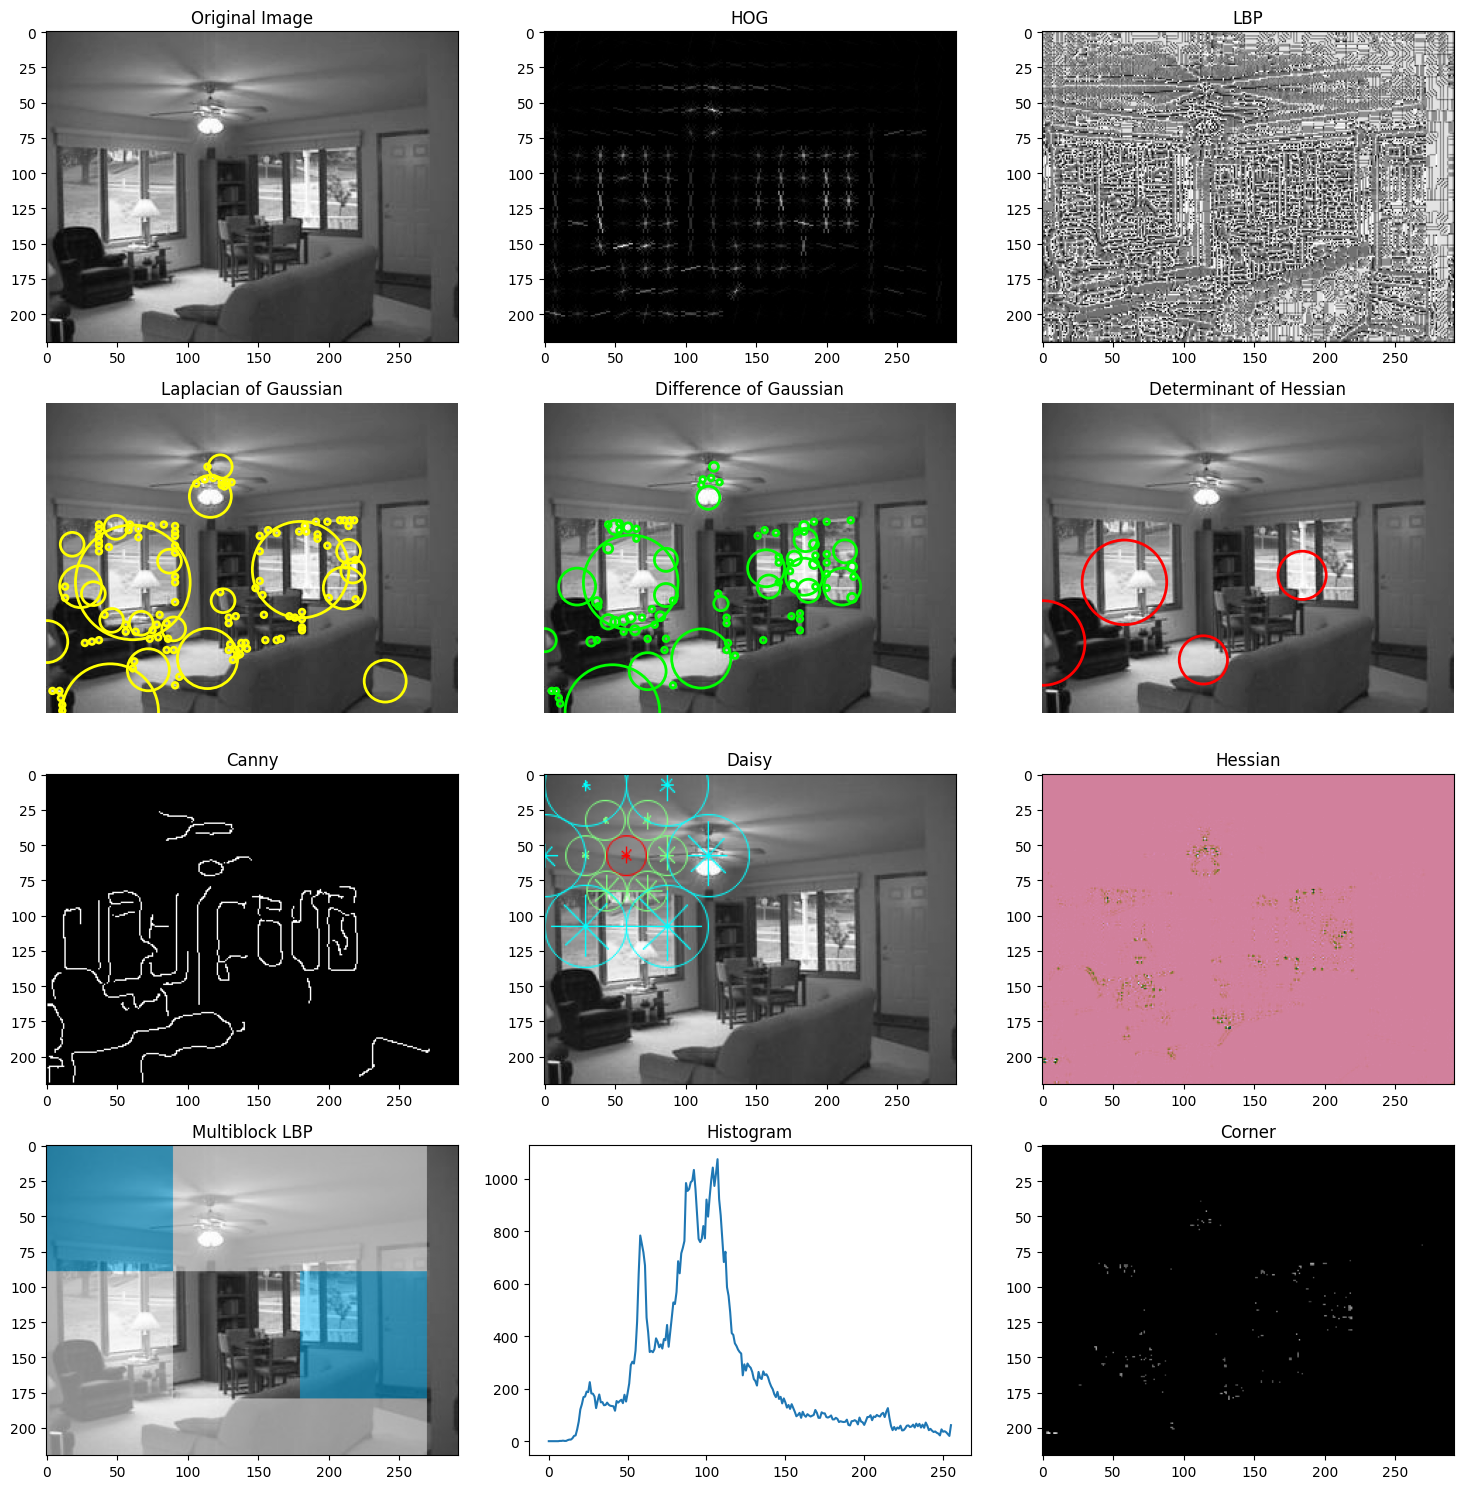

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt

features = list(img_ft.keys())
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
axs = axs.ravel()

# Original Image
axs[0].imshow(img_ft["none"], cmap="gray")
axs[0].set_title("Original Image")

# hog
axs[1].imshow(img_ft["hog"][1], cmap="gray")
axs[1].set_title("HOG")
# lbp
axs[2].imshow(img_ft["lbp"], cmap="gray")
axs[2].set_title("LBP")

# blob_log, blob_dog, blob_doh
blobs_log = img_ft["blob_log"]
# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
blobs_dog = img_ft["blob_dog"]
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)
blobs_doh = img_ft["blob_doh"]
blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ["yellow", "lime", "red"]
titles = ["Laplacian of Gaussian", "Difference of Gaussian", "Determinant of Hessian"]
sequence = zip(blobs_list, colors, titles)
for idx, (blobs, color, title) in enumerate(sequence):
    cur_idx = 3 + idx
    axs[cur_idx].imshow(img_ft["none"], cmap="gray")
    axs[cur_idx].set_title(title)
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        axs[cur_idx].add_patch(c)
    axs[cur_idx].set_axis_off()

# canny
axs[6].imshow(img_ft["canny"], cmap="gray")
axs[6].set_title("Canny")
# daisy
axs[7].imshow(img_ft["daisy"][1], cmap="gray")
axs[7].set_title("Daisy")
# hessian
#axs[8].imshow(img_ft["hessian"], cmap="nipy_spectral")
axs[8].imshow(img_ft["hessian"], cmap="cubehelix")
axs[8].set_title("Hessian")
# multiblock_lbp
axs[9].imshow(img_ft["multiblock_lbp"], cmap="gray")
axs[9].set_title("Multiblock LBP")
# histogram
axs[10].plot(img_ft["histogram"])
axs[10].set_title("Histogram")
# corner
axs[11].imshow(img_ft["corner"], cmap="gray")
axs[11].set_title("Corner")

plt.tight_layout()
plt.show()